Submission Proyek Akhir kelas Belajar Machine Learning untuk Pemula by Dicoding.

Nama: Andi Abdul Hafez Ramadhan

Email: etchzel@gmail.com

Menghubungkan google drive ke notebook karena saya akan menyimpan dataset nya di folder google drive saya

In [ ]:
#mounting my drive to the notebook
from google.colab import drive
drive.mount('/content/drive')

Download dataset yg di sediakan oleh Dicoding lalu disimpan di google drive

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /content/drive/MyDrive/Datasets/rockpaperscissors.zip

--2021-06-30 22:16:38--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/drive/MyDrive/Datasets/rockpaperscissors.zip’

/content/drive/MyDr 100%[===================>] 307.92M  6.33MB/s    in 59s     

2021-06-30 22:17:39 (5.21 MB/s) - ‘/content/drive/MyDrive/Datasets/rockpaperscissors.zip’ saved [322873683/322873683]



Ekstrak file zip yg baru di download lalu tetapkan direktori dataset

In [1]:
import zipfile, os

In [ ]:
local_zip = '/content/drive/MyDrive/Datasets/rockpaperscissors.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Datasets/')
zip_ref.close()

In [2]:
#set the directory for our dataset
base_dir = '/content/drive/MyDrive/Datasets/'
dataset_dir = os.path.join(base_dir, 'rockpaperscissors')

Hapus file dan folder yang tidak diperlukan menggunakan rm command

In [ ]:
!rm /content/drive/MyDrive/Datasets/rockpaperscissors/README_rpc-cv-images.txt
!rm -rf /content/drive/MyDrive/Datasets/rockpaperscissors/rps-cv-images

In [3]:
os.listdir(dataset_dir)

['paper', 'rock', 'scissors']

Import semua library yg diperlukan

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras.preprocessing import image
from time import time

%matplotlib inline

Buat augmentasi gambar menggunakan image generator. Parameter validation_split digunakan untuk membagi dataset untuk training dan validation

In [5]:
image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.4
)

In [6]:
train_generator = image_generator.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    subset='training'
)

validation_generator = image_generator.flow_from_directory(
    dataset_dir,
    target_size = (150, 150),
    batch_size=32,
    shuffle=True,
    subset='validation'
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


Buat model sequential

In [7]:
#template function for convolution layer
def conv_layer(filter_num, padding='same'):
  return tf.keras.layers.Conv2D(
      filters=filter_num,
      kernel_size=(3,3),
      padding=padding,
      activation='relu'
  )

#template function for pooling layer
def pool_layer():
  return tf.keras.layers.MaxPooling2D(
      pool_size=(2,2),
      strides=(2,2)
  )

#function that add sequence of layers for our model
def layer_sequence(model):
  model.add(tf.keras.layers.InputLayer(input_shape=(150,150,3)))
  
  model.add(conv_layer(16))
  model.add(conv_layer(16))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(pool_layer())

  model.add(conv_layer(32,'valid'))
  model.add(conv_layer(32,'valid'))
  model.add(pool_layer())

  model.add(conv_layer(64,'valid'))
  model.add(conv_layer(64,'valid'))
  model.add(pool_layer())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(224, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [8]:
model = tf.keras.models.Sequential()

layer_sequence(model)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 73, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0

Buat list callbacks yg akan digunakan

In [9]:
#custom callback to get the training time
class TrainingTimeCallback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.train_time = []

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_start_time=time()
  
  def on_epoch_end(self, epoch, logs={}):
    self.train_time.append(time() - self.epoch_start_time)

  def on_train_end(self, logs={}):
    self.total_train_time = sum(self.train_time)/60.0
    print('Training finished. Total training time: {0:d} minutes {1:.2f} seconds'.format(
        int(self.total_train_time),
        (self.total_train_time*60.0)%60.0
    ))

In [10]:
#callback for early stopping of training when parameter does not improve
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

checkpoint_path = os.path.join(
    base_dir,
    'rockpaperscissors-checkpoints',
    'rps_model.h5'
)
#callback to save best model during training
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

time_callback = TrainingTimeCallback()

In [11]:
train_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[checkpoints, time_callback, early],
    verbose=1
)

Epoch 1/50
41/41 [==============================] - 103s 3s/step - loss: 0.7645 - accuracy: 0.6466 - val_loss: 1.0601 - val_accuracy: 0.3472

Epoch 00001: val_accuracy improved from -inf to 0.34722, saving model to /content/drive/MyDrive/Datasets/rockpaperscissors-checkpoints/rps_model.h5
Epoch 2/50
41/41 [==============================] - 102s 2s/step - loss: 0.3075 - accuracy: 0.8918 - val_loss: 0.9229 - val_accuracy: 0.7326

Epoch 00002: val_accuracy improved from 0.34722 to 0.73264, saving model to /content/drive/MyDrive/Datasets/rockpaperscissors-checkpoints/rps_model.h5
Epoch 3/50
41/41 [==============================] - 99s 2s/step - loss: 0.2189 - accuracy: 0.9282 - val_loss: 0.8267 - val_accuracy: 0.6586

Epoch 00003: val_accuracy did not improve from 0.73264
Epoch 4/50
41/41 [==============================] - 99s 2s/step - loss: 0.1538 - accuracy: 0.9477 - val_loss: 0.6076 - val_accuracy: 0.7373

Epoch 00004: val_accuracy improved from 0.73264 to 0.73727, saving model to /con

Plot grafik perkembangan selama training

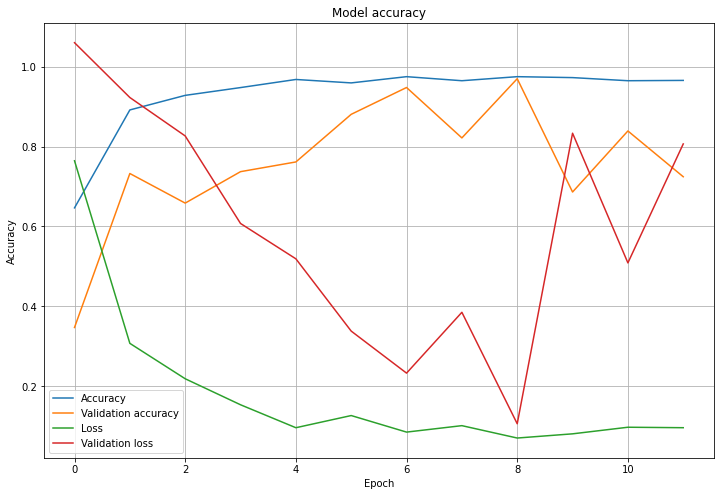

In [12]:
plt.figure(figsize=(12,8))
metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
legends = ['Accuracy', 'Validation accuracy', 'Loss', 'Validation loss']
for metric in metrics:
  plt.plot(train_history.history[metric])

plt.grid(True)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(legends)
plt.show()

Test evaluasi model

In [13]:
model.evaluate(
    validation_generator,
    steps=validation_generator.n // validation_generator.batch_size,
    verbose=1
)

27/27 [==============================] - 19s 698ms/step - loss: 0.1102 - accuracy: 0.9688


[0.11017870157957077, 0.96875]

Set direktori test data yg sudah di simpan di google drive sebelum nya.
Test data diperoleh dengan manual.

In [14]:
test_images_path = os.path.join(base_dir, 'rockpaperscissors-test')
os.listdir(test_images_path)

['paper', 'rock', 'scissors']

Buat image generator untuk test data

In [15]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    horizontal_flip = True,
    #shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
)

test_generator = test_datagen.flow_from_directory(
    test_images_path,
    target_size = (150,150),
    batch_size = 1,
    class_mode = None,
    shuffle = False
)

Found 15 images belonging to 3 classes.


Prediction menggunakan test data

In [16]:
#reset the generator to the 1st batch
test_generator.reset()
pred = model.predict(
    test_generator,
    steps=test_generator.n // test_generator.batch_size,
    verbose=1
)

15/15 [==============================] - 1s 28ms/step


In [17]:
#get the class labels from the train generator
labels = train_generator.class_indices

#swap the key and value pairs
labels = dict((value,key) for key,value in labels.items())

#obtain the predictions using the labels and the prediction value
predictions = [labels[prediction] for prediction in pred.argmax(axis=1)]

#grab the file paths of all the test images
test_img_filepaths = test_generator.filepaths

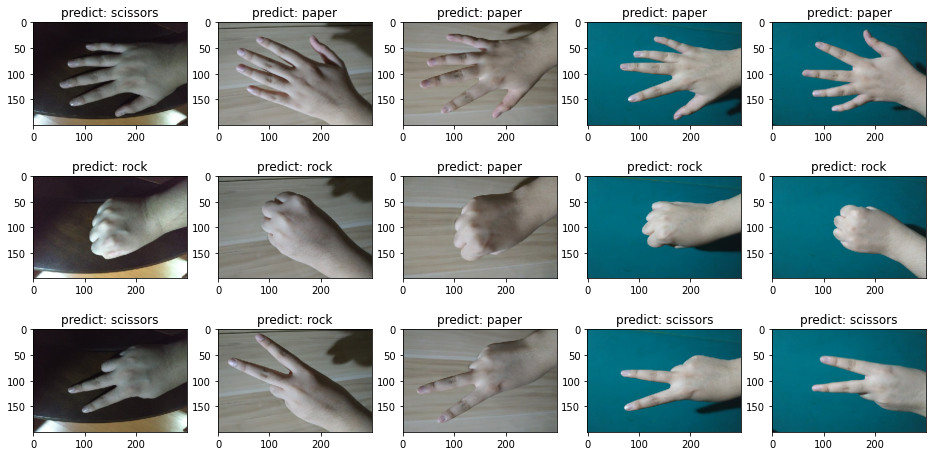

In [18]:
plt.figure(figsize=(16,8))
i = 1
for img_paths, img_pred in zip(test_img_filepaths, predictions):
  test_img = image.load_img(img_paths, target_size=(200,300))
  plt.subplot(3, 5, i)
  plt.imshow(test_img)
  plt.title('predict: {}'.format(img_pred))
  i += 1

plt.show()

Menambahkan prediksi untuk file yg ingin di unggah ke Google Colab

In [21]:
def predict_upload(uploaded):
  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images= np.vstack([x])
    classes = model.predict(images, batch_size=16)

    print(fn)
    print(classes)
    if (classes[0][0] == 1):
      print('paper')
    elif (classes[0][1] == 1):
      print('rock')
    elif (classes[0][2] == 1):
      print('scissors')

Saving 3_scissors.jpg to 3_scissors.jpg
3_scissors.jpg
[[0. 0. 1.]]
scissors


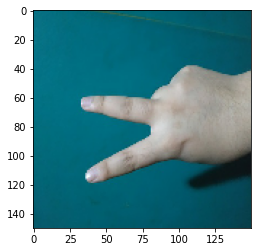

In [22]:
uploaded = files.upload()
predict_upload(uploaded)